In [25]:
import pandas
import numpy
from matplotlib import pyplot
import missingno
from sklearn.impute import KNNImputer
from numpy import isnan
from sklearn.model_selection import train_test_split
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

In [3]:
dataset = pandas.read_csv("datasets/frmgham2.csv")
dataset.sample(10)

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
8509,7314068,1,229.0,57,144.0,88.0,0,0.0,23.96,0,...,0,1,5538,5538,5538,5538,5538,5538,5538,4401
6897,6007589,2,216.0,51,195.0,94.0,1,12.0,29.45,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,0
10696,9211709,1,178.0,66,128.0,65.0,1,20.0,28.74,0,...,1,1,7436,7436,7436,0,7436,0,7436,2170
9318,8006181,1,268.0,58,122.5,89.5,0,0.0,23.81,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,1338
9260,7947614,1,221.0,68,155.0,74.0,0,0.0,27.44,0,...,0,1,8101,8101,8101,8101,8101,8101,8101,0
11366,9763396,1,238.0,64,143.0,83.0,0,0.0,23.72,0,...,1,1,955,6833,308,308,6833,308,6833,1294
3850,3287574,1,212.0,48,139.0,86.0,1,30.0,20.27,0,...,0,0,759,759,759,759,759,759,8766,759
10135,8787358,1,262.0,50,145.0,85.0,0,0.0,26.22,0,...,0,1,8766,8766,8766,8766,8766,8766,8766,0
5595,4764394,1,229.0,38,116.0,70.0,1,7.0,26.65,0,...,1,0,7184,7110,7110,7110,7184,7110,7184,7184
237,205391,1,286.0,62,117.5,80.0,1,20.0,31.56,1,...,1,0,1833,0,0,0,1833,0,1833,1833


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11627 entries, 0 to 11626
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RANDID    11627 non-null  int64  
 1   SEX       11627 non-null  int64  
 2   TOTCHOL   11218 non-null  float64
 3   AGE       11627 non-null  int64  
 4   SYSBP     11627 non-null  float64
 5   DIABP     11627 non-null  float64
 6   CURSMOKE  11627 non-null  int64  
 7   CIGPDAY   11548 non-null  float64
 8   BMI       11575 non-null  float64
 9   DIABETES  11627 non-null  int64  
 10  BPMEDS    11034 non-null  float64
 11  HEARTRTE  11621 non-null  float64
 12  GLUCOSE   10187 non-null  float64
 13  educ      11332 non-null  float64
 14  PREVCHD   11627 non-null  int64  
 15  PREVAP    11627 non-null  int64  
 16  PREVMI    11627 non-null  int64  
 17  PREVSTRK  11627 non-null  int64  
 18  PREVHYP   11627 non-null  int64  
 19  TIME      11627 non-null  int64  
 20  PERIOD    11627 non-null  in

In [5]:
dataset["ANYCHD"].value_counts()

0    8469
1    3158
Name: ANYCHD, dtype: int64

In [6]:
colunas = ["SEX", "TOTCHOL", "AGE", "SYSBP", "DIABP", "CURSMOKE",
           "CIGPDAY", "BMI", "DIABETES", "BPMEDS", "HEARTRTE",
           "GLUCOSE", "educ", "HDLC", "LDLC", "ANYCHD", "PERIOD"]

dataset2 = dataset[colunas].copy()

In [7]:
dataset2["PERIOD"].value_counts()

1    4434
2    3930
3    3263
Name: PERIOD, dtype: int64

In [8]:
dataset2 = dataset2[dataset2["PERIOD"] == 3]
dataset2.drop(columns="PERIOD", inplace=True)
dataset2.sample(10)

,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,BPMEDS,HEARTRTE,GLUCOSE,educ,HDLC,LDLC,ANYCHD
7963,1,301.0,64,124.0,77.0,0,0.0,31.35,0,0.0,70.0,68.0,NaN,52.0,249.0,1
6016,2,189.0,62,135.0,72.0,0,0.0,24.08,0,NaN,65.0,76.0,2.0,56.0,120.0,0
764,2,NaN,51,150.0,100.0,0,0.0,23.65,0,0.0,80.0,NaN,4.0,NaN,NaN,0
10275,2,293.0,71,157.0,85.0,0,0.0,26.42,0,0.0,90.0,87.0,2.0,64.0,176.0,0
1018,2,245.0,67,166.0,96.0,0,0.0,34.69,0,0.0,98.0,NaN,4.0,43.0,202.0,0
2257,2,256.0,67,144.0,77.0,0,0.0,26.84,0,0.0,85.0,145.0,1.0,34.0,152.0,0
4466,1,330.0,50,131.0,83.0,1,20.0,26.20,0,0.0,75.0,87.0,1.0,34.0,296.0,1
3942,2,254.0,60,106.0,68.0,0,0.0,24.25,0,0.0,100.0,80.0,2.0,54.0,184.0,0
10411,1,197.0,55,160.5,84.5,0,0.0,28.24,0,1.0,85.0,106.0,2.0,31.0,166.0,1
8337,1,249.0,70,164.0,90.0,0,0.0,23.72,0,NaN,90.0,102.0,1.0,35.0,179.0,0


<AxesSubplot:>

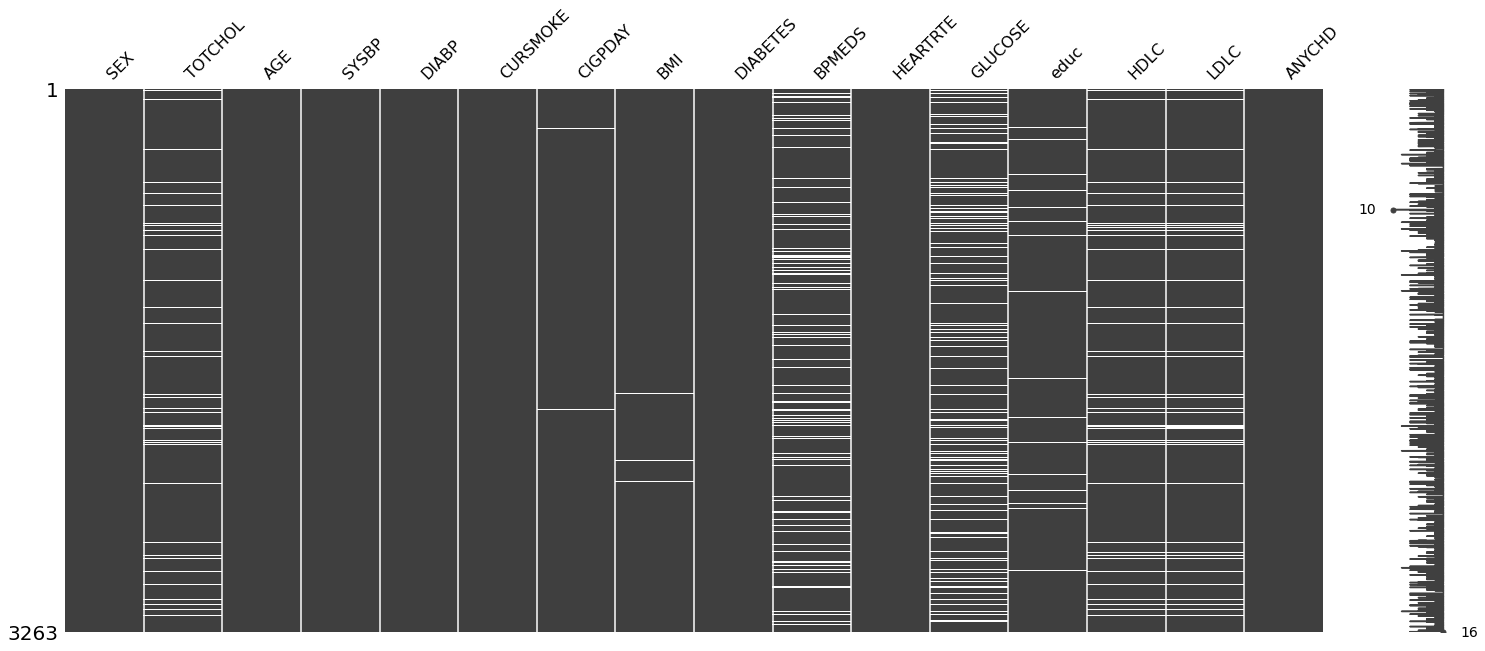

In [9]:
missingno.matrix(dataset2)

<AxesSubplot:>

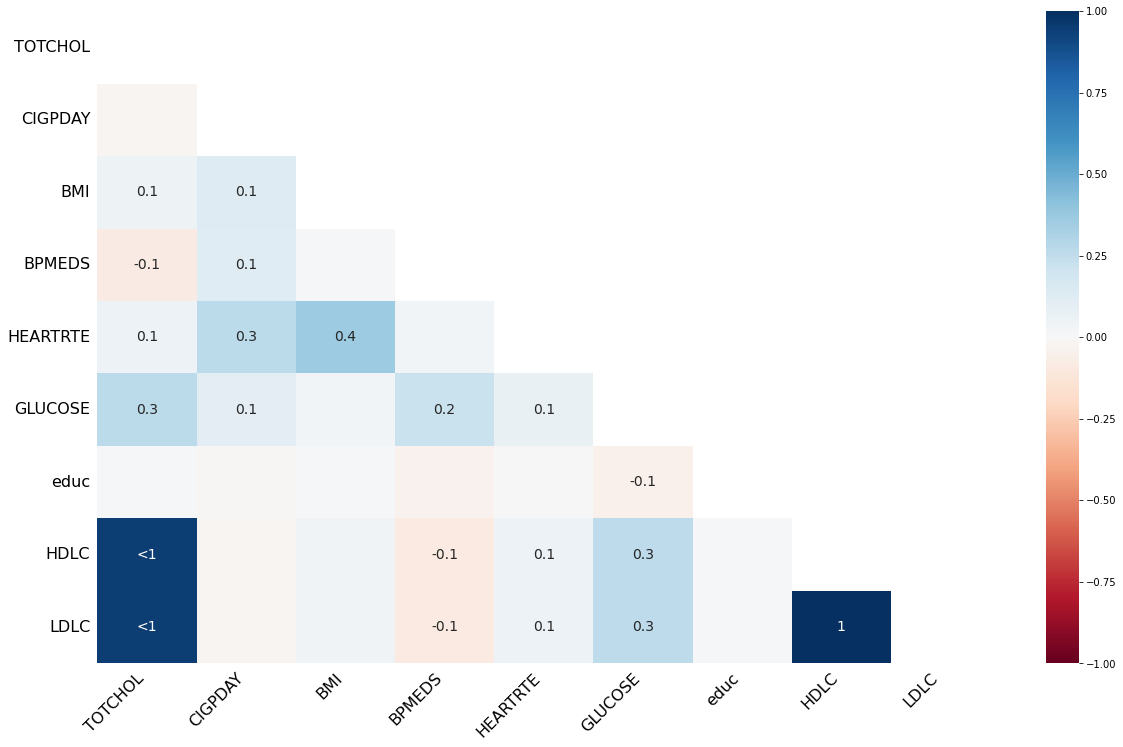

In [10]:
missingno.heatmap(dataset2)

In [11]:
features = dataset2.drop(columns=["ANYCHD"])
target = dataset2["ANYCHD"]

feature_list = list(features.columns)

In [12]:
features = numpy.array(features)
target = numpy.array(target)

In [13]:
print("Missing: ", sum(isnan(features).flatten()))

imputer = KNNImputer(missing_values=numpy.nan)
imputer.fit(features)
filled_features = imputer.transform(features)

print("Missing: ", sum(isnan(filled_features).flatten()))

Missing:  1812
Missing:  0


In [17]:
x_train, x_val, y_train, y_val = train_test_split(
    filled_features,
    target,
    test_size=0.3,
    random_state=8
)

x_val, x_test, y_val, y_test = train_test_split(
    x_val,
    y_val,
    test_size=0.5
)

In [19]:
numpy.random.seed(8)

In [22]:
model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": 2e-2},
    n_steps=5,
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={
        "step_size": 10,
        "gamma": 0.5
    }
)

Device used : cpu


In [23]:
model.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=["train", "validation"],
    eval_metric=["accuracy", "balanced_accuracy"],
    max_epochs=1000,
    patience=50,
    batch_size=256
)

epoch 0  | loss: 0.65551 | train_accuracy: 0.35026 | train_balanced_accuracy: 0.45514 | validation_accuracy: 0.32924 | validation_balanced_accuracy: 0.46005 |  0:00:00s
epoch 1  | loss: 0.58105 | train_accuracy: 0.33144 | train_balanced_accuracy: 0.47985 | validation_accuracy: 0.32311 | validation_balanced_accuracy: 0.49203 |  0:00:01s
epoch 2  | loss: 0.56472 | train_accuracy: 0.43082 | train_balanced_accuracy: 0.50204 | validation_accuracy: 0.3681  | validation_balanced_accuracy: 0.43039 |  0:00:01s
epoch 3  | loss: 0.55318 | train_accuracy: 0.41112 | train_balanced_accuracy: 0.47732 | validation_accuracy: 0.46012 | validation_balanced_accuracy: 0.52759 |  0:00:01s
epoch 4  | loss: 0.5456  | train_accuracy: 0.40236 | train_balanced_accuracy: 0.52838 | validation_accuracy: 0.37628 | validation_balanced_accuracy: 0.50517 |  0:00:02s
epoch 5  | loss: 0.5558  | train_accuracy: 0.55298 | train_balanced_accuracy: 0.50002 | validation_accuracy: 0.53579 | validation_balanced_accuracy: 0.4724

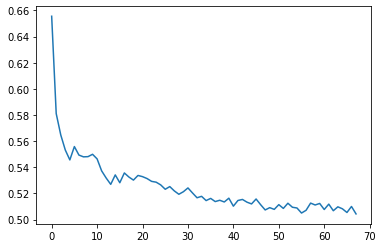

In [28]:
pyplot.plot(model.history["loss"])

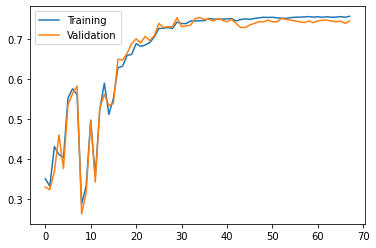

In [37]:
pyplot.plot(model.history["train_accuracy"], label="Training")
pyplot.plot(model.history["validation_accuracy"], label="Validation")
pyplot.legend();

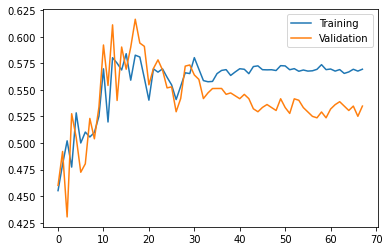

In [36]:
pyplot.plot(model.history["train_balanced_accuracy"], label="Training")
pyplot.plot(model.history["validation_balanced_accuracy"], label="Validation")
pyplot.legend();

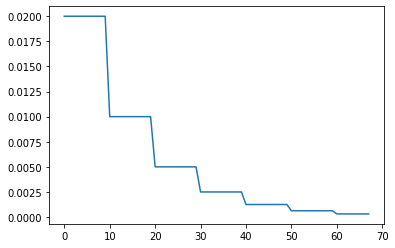

In [38]:
pyplot.plot(model.history["lr"])

In [41]:
y_pred = model.predict(x_test)
test_accuracy = balanced_accuracy_score(y_pred, y_test)

y_pred_validation = model.predict(x_val)
validation_accuracy = balanced_accuracy_score(y_pred_validation, y_val)

print("Test acc:", test_accuracy)
print("Validation acc:", validation_accuracy)

Test acc: 0.5842805979445655
Validation acc: 0.5922652916073968


In [49]:
model.feature_importances_

array([0.00429962, 0.00803127, 0.01437105, 0.01664411, 0.01712346,
       0.01741447, 0.0182276 , 0.03095976, 0.03426457, 0.04644627,
       0.04843539, 0.05852697, 0.06704777, 0.06791665, 0.55029106])